# Tracing Google ADK agents with Agenta

This notebook shows how to:

- Build a simple Google ADK agent using Gemini.
- Instrument it with `openinference-instrumentation-google-adk`.
- Send traces to Agenta using the `agenta` Python SDK.
- Inspect the traces in the Agenta Observability UI.

> **Prerequisites**
> - Agenta account and API key  
> - Google API key (for Gemini models)

## Implementation Guide

Follow this tutorial to set up Google ADK with Agenta’s observability platform and enable end-to-end tracing for your agent workflows.

### Step 1: Install Required Dependencies

Install the necessary Python packages for this integration:

In [ ]:
%pip install -U agenta google-adk openinference-instrumentation-google-adk nest_asyncio openai

  Using cached google_adk-1.19.0-py3-none-any.whl.metadata (13 kB)
  Using cached aiosqlite-0.21.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached google_cloud_bigquery_storage-2.34.0-py3-none-any.whl.metadata (10 kB)
  Using cached google_cloud_discoveryengine-0.13.12-py3-none-any.whl.metadata (9.6 kB)
  Using cached google_cloud_storage-3.6.0-py3-none-any.whl.metadata (13 kB)
INFO: pip is looking at multiple versions of google-adk to determine which version is compatible with other requirements. This could take a while.
  Using cached google_adk-1.18.0-py3-none-any.whl.metadata (13 kB)
  Using cached google_adk-1.17.0-py3-none-any.whl.metadata (14 kB)
  Using cached google_adk-1.16.0-py3-none-any.whl.metadata (12 kB)
  Using cached google_adk-1.15.1-py3-none-any.whl.metadata (12 kB)
  Using cached google_genai-1.40.0-py3-none-any.whl.metadata (45 kB)
  Using cached google_adk-1.15.0-py3-none-any.whl.metadata (12 kB)
  Using cached google_genai-1.36.0-py3-none-any.whl.metadata (43 k

**Package Descriptions:**
- `agenta`: Core SDK that enables tracing, observability, and evaluation inside Agenta.
- `google-adk`: Google’s Agent Development Kit for building agents powered by Gemini models and tools.
- `openinference-instrumentation-google-adk`: Automatic instrumentation library that generates OpenTelemetry traces for Google ADK agent runs, tool calls, and model interactions.


### Step 2: Setup and Configuration

Configure your environment and initialize the Agenta SDK:

In [ ]:
import os
import nest_asyncio

import agenta as ag
from openinference.instrumentation.google_adk import GoogleADKInstrumentor

# Enable nested event loops inside Jupyter
nest_asyncio.apply()

# Load configuration from environment
os.environ["AGENTA_API_KEY"] = "YOUR AGENTA API KEY"
os.environ["AGENTA_HOST"] = "https://cloud.agenta.ai"
os.environ["GOOGLE_API_KEY"] = "YOUR GOOGLE API KEY"   # Required for Google ADK / Gemini

# Initialize Agenta (uses AGENTA_* env vars)
ag.init()


2025-11-25T23:03:34.935Z [INFO.] Agenta -  SDK ver: 0.63.0 [agenta.sdk.agenta_init] 
2025-11-25T23:03:34.936Z [INFO.] Agenta -  API URL: https://cloud.agenta.ai/api [agenta.sdk.agenta_init] 
2025-11-25T23:03:34.937Z [INFO.] Agenta - OLTP URL: https://cloud.agenta.ai/api/otlp/v1/traces [agenta.sdk.tracing.tracing] 


**What does `ag.init()` do?**
This function initializes the Agenta SDK and sets up the necessary configuration for observability. It establishes connection to the Agenta platform, configures tracing and logging settings, and prepares the instrumentation context for your application.

### Step 3: Enable Google ADK automatic monitoring


Initialize the OpenInference Google ADK instrumentation to automatically capture agent operations:


In [3]:
# Enable Google ADK automatic monitoring
GoogleADKInstrumentor().instrument()

c:\Users\Sirous\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\aiplatform\models.py:52: FutureWarning: Support for google-cloud-storage < 3.0.0 will be removed in a future version of google-cloud-aiplatform. Please upgrade to google-cloud-storage >= 3.0.0.
  from google.cloud.aiplatform.utils import gcs_utils


### Step 4: Build Your Instrumented Google ADK Application

The following example defines a weather agent using Google ADK and wraps the main workflow with Agenta instrumentation so each request is fully traced:


In [11]:
from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai import types

APP_NAME = "weather_app"
USER_ID = "demo_user"

def get_weather(city: str) -> dict:
    """Toy tool used to generate spans in our traces."""
    normalized = city.strip().lower()
    if normalized == "new york":
        return {
            "status": "success",
            "report": "The weather in New York is sunny with a temperature of 25°C.",
        }
    if normalized == "london":
        return{
            "status": "success",
            "report": "The weather in London is cloudy with a temperature of 18°C.",
        }
    else:
        return {
            "status": "error",
            "error_message": f"Weather information for '{city}' is not available.",
        }

weather_agent = Agent(
    name="weather_agent",
    model="gemini-2.0-flash-exp",
    description="Agent that answers simple weather questions using a tool.",
    instruction="You must use the tools to answer the user's question.",
    tools=[get_weather],
)

session_service = InMemorySessionService()
weather_runner = Runner(agent=weather_agent , app_name=APP_NAME, session_service=session_service)


In [12]:
import asyncio
from google.genai import types
import agenta as ag

@ag.instrument(spankind="workflow")
async def ask_weather(question: str, user_id: str = "demo_user")-> str:
    """
    Run a single weather question through the Google ADK agent.
    This appears as a top-level span inside Agenta observability.
    """

    # Create a session for this user
    session = await session_service.create_session(
        app_name=APP_NAME,
        user_id=user_id,
    )

    content = types.Content(
        role="user",
        parts=[types.Part.from_text(text=question)],
    )


    try:
        events = weather_runner.run_async(
            user_id=user_id,
            session_id=session.id,
            new_message=content,
    )

        final_text = ""
        async for event in events:
            if event.is_final_response():
                final_text = event.content.parts[0].text.strip()

        return final_text

    except Exception as exc:
        # Basic handling for Gemini quota / resource exhaustion
        msg = str(exc).lower()
        if "exhausted" in msg:
            return (
                "The model is temporarily exhausted or over quota. (Check you 'google gemini' subscription) "
            )
        # Re-raise all other errors so you still see real issues
        raise


### Step 5: Run the Example

In [14]:
# Example usage 
async def main(): 
  response = await ask_weather("What is the weather in New York?") 
  print("Response:", response) 

# Run the example 
await main()

Response: The model is temporarily exhausted or over quota. (Check you 'google gemini' subscription) 


![weather example observability.JPG](<attachment:weather example observability.JPG>)
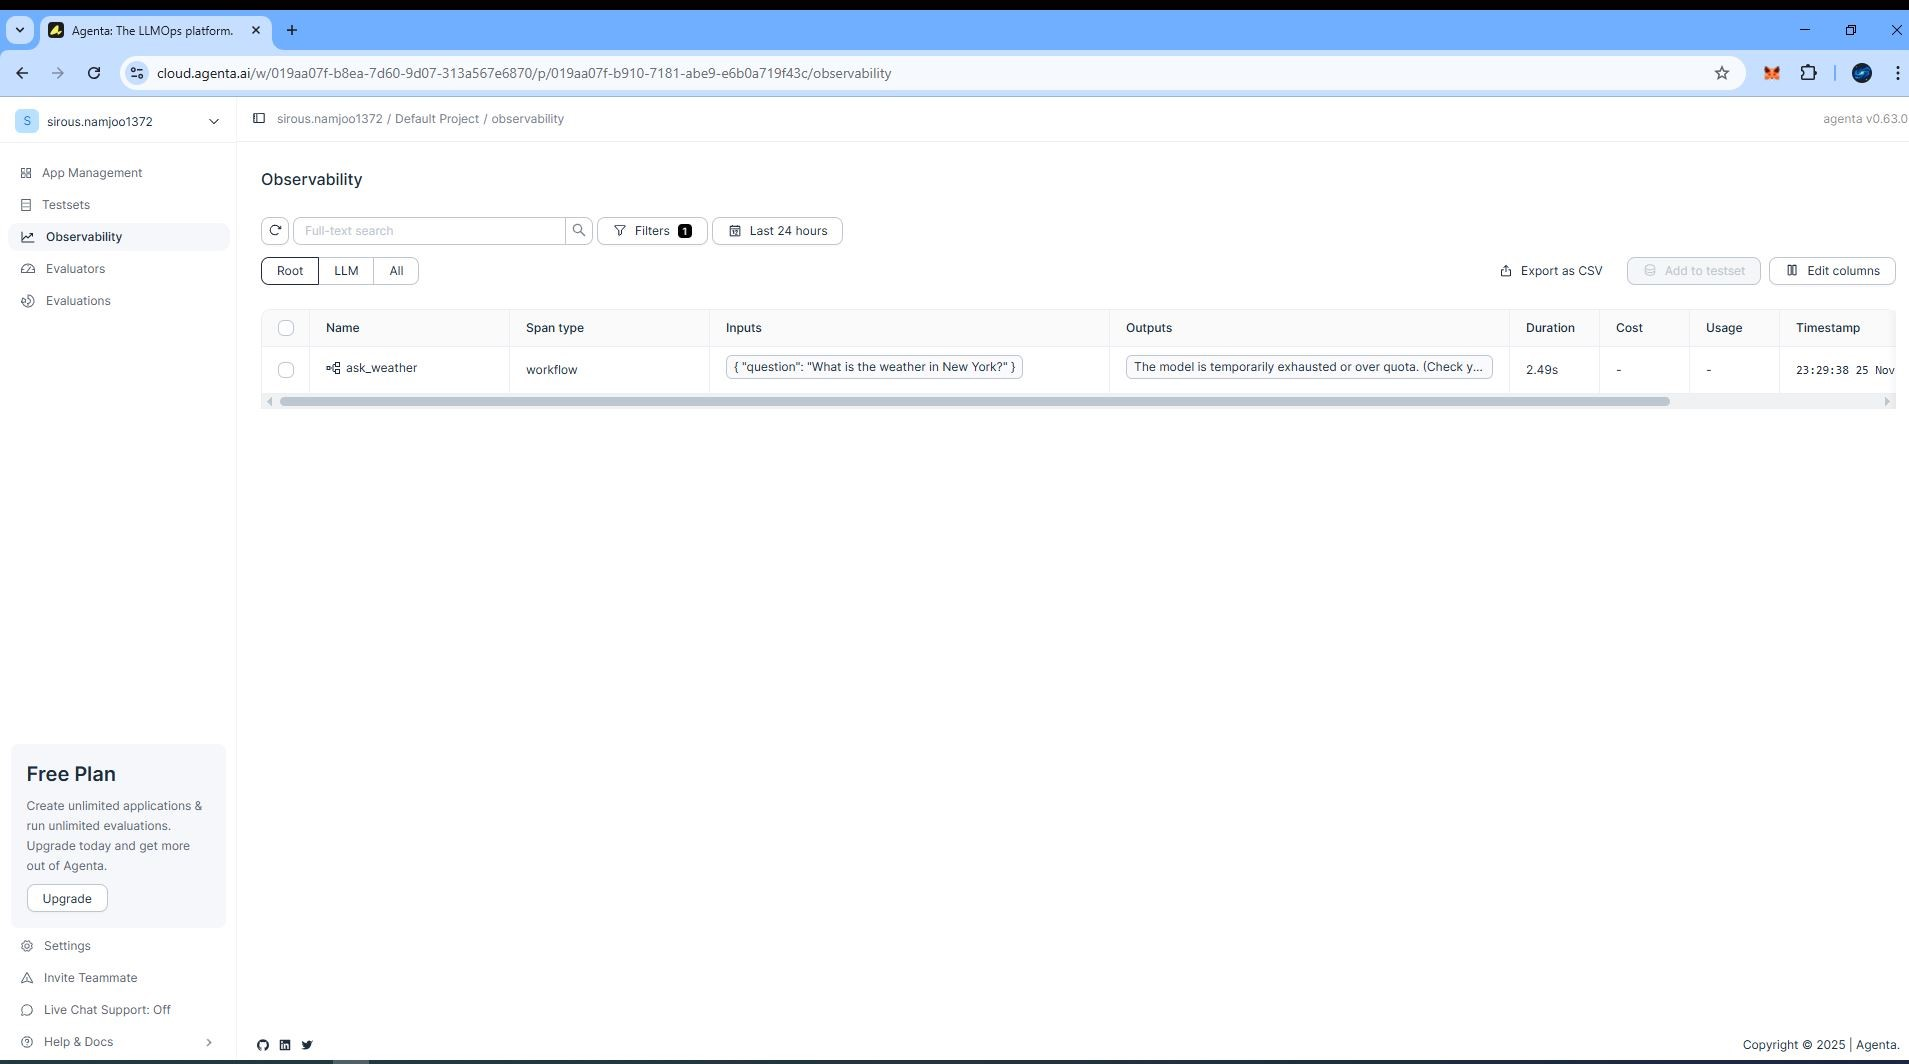

![weather example observability - detailed trace.JPG](<attachment:weather example observability - detailed trace.JPG>)
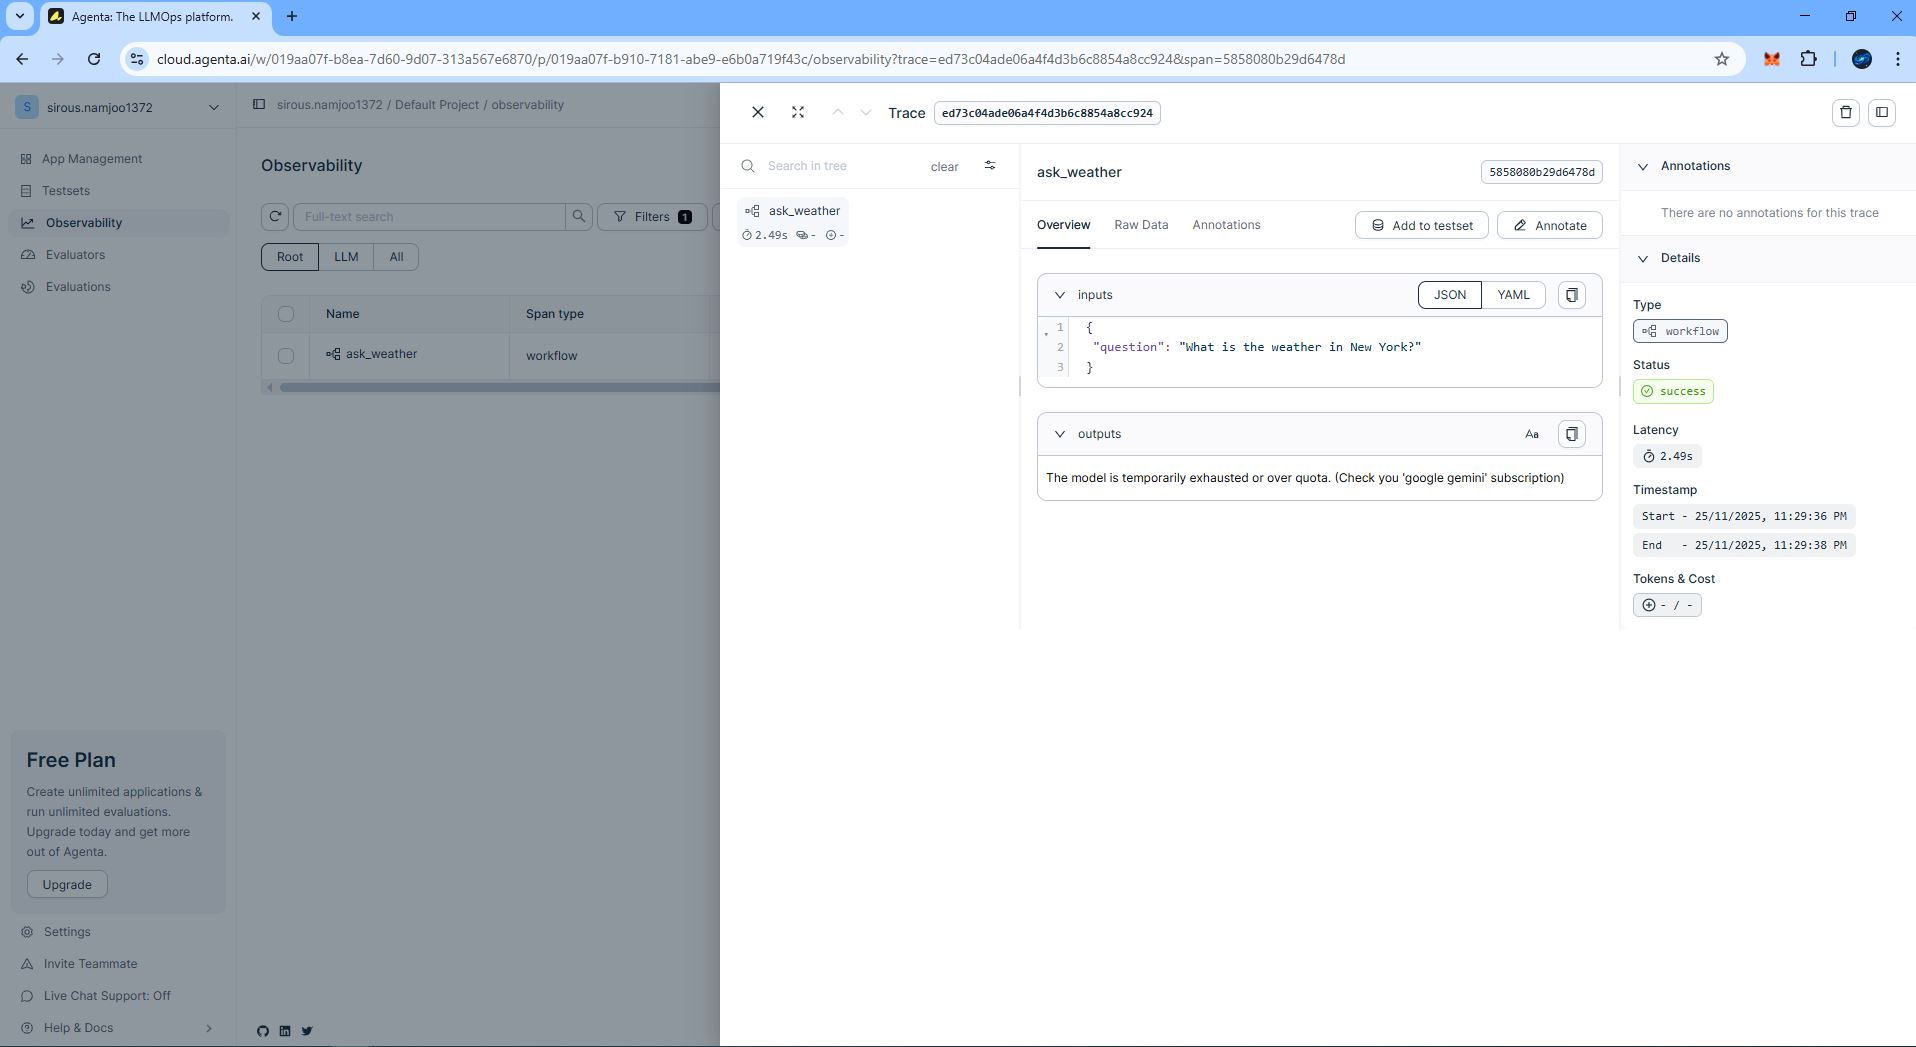

### Step 6: Understanding the `@ag.instrument()` Decorator

The `@ag.instrument()` decorator allows you to trace a Python function without writing any manual telemetry code.  
When used on a function, Agenta automatically records:

- the function’s input arguments  
- the returned output  
- execution duration  
- any errors raised  
- all nested spans generated inside the function (including Google ADK agent/tool/model spans)

This makes the function appear as a **top-level trace** inside Agenta’s Observability UI.

---

#### Choosing a Span Type (`spankind`)

You can categorize the function in Agenta by setting the `spankind` parameter:

- **workflow** – full application processes or main entrypoints  
- **agent** – agent-specific logic or reasoning  
- **tool** – helper functions or utilities  
- **completion** – text/model generation  
- **chat** – conversational request/response flows  
- **query** – retrieval or lookup operations  

Example:

```python
@ag.instrument(spankind="workflow")
async def ask_weather(...):
    ...


In [15]:
# Example with custom span classification:
import agenta as ag

@ag.instrument(spankind="agent")
def specialized_agent_function(input_data: str):
    # Agent-specific logic implementation (placeholder)
    return input_data.upper()
    

### Step 7: View Traces in Agenta

After running your instrumented function, you can inspect all execution traces inside the Agenta dashboard.  
The recorded observability data typically includes:

- Top-level workflow span for your `ask_weather()` call  
- Nested spans generated by Google ADK  
- Tool invocation spans (e.g., `get_weather`)  
- Model call information for Gemini requests  
- Input/output data captured by the instrumentation  
- Execution timing and performance metrics  

These traces help you:

- Understand how your Google ADK agent processes a request  
- Debug tool behaviors and model interactions  
- Monitor latency and performance  
- Verify that your agent is behaving as expected

You can access all traces under **Observability → Traces** in the Agenta UI.


## Advanced Usage

### Custom Span Configuration

You can apply `@ag.instrument()` to any function in your application to categorize different operations inside Agenta.  
Below are examples showing how to instrument workflows, agent logic, and tool integrations in a Google ADK application.


In [16]:
import agenta as ag

# Instrument a full application workflow
@ag.instrument(spankind="workflow")
async def weather_query_pipeline(question: str)-> str:
    """Wraps ask_weather as a higher-level workflow."""
    return await ask_weather(question)


# Instrument additional agent-side logic
@ag.instrument(spankind="agent")
def preprocess_user_input(text: str)-> str:
    # Example: normalize punctuation, strip whitespace
    return text.strip().lower()


# Instrument external helper/tool functions
@ag.instrument(spankind="tool")
def fetch_external_data(param: str)-> dict:
    # This represents a non-ADK helper tool
    return {"raw_data": f"Fetched data for {param}"}


These custom spans allow you to:

- Track individual parts of your application  
- Separate agent logic from tool behavior  
- Visualize helper functions alongside Google ADK operations  
- Build rich, hierarchical traces for debugging and performance analysis  


### Real-World Example  
#### Customer Support Assistant Using Google ADK

This example shows how a support assistant can route inquiries to different tool functions  
(billing, technical support, general help). Each tool can be individually instrumented  
for observability.


In [17]:
from google.adk.agents import Agent
from google.adk.runners import InMemoryRunner
from google.genai import types
import agenta as ag

SUPPORT_APP_NAME = "customer_support_app"

# ---- Define specialized support tools ----

@ag.instrument(spankind="tool")
def general_support(query: str)-> str:
    return (
        f"General Support: I can help with basic questions about your account. You asked: {query}"
    )

@ag.instrument(spankind="tool")
def billing_support(query: str)-> str:
    return (
        f"Billing Support: I can assist with invoices, refunds, and payments. You asked: {query}"
    )

@ag.instrument(spankind="tool")
def technical_support(query: str)-> str:
    return (
        f"Technical Support: I can help troubleshoot technical issues. You asked: {query}"
    )


# ---- Define the main support agent ----

support_agent = Agent(
    name="customer_support_agent",
    model="gemini-2.0-flash-exp",
    description="Routes customer queries to the appropriate support tool.",
    instruction=(
        "You are a support assistant. "
        "Determine if the question is billing, technical, or general, "
        "and call the appropriate tool."
    ),
    tools=[general_support, billing_support, technical_support],
)


support_runner = InMemoryRunner(agent=support_agent, app_name=SUPPORT_APP_NAME)


# ---- Workflow instrumented with Agenta ----

@ag.instrument(spankind="workflow")
async def customer_support_system(query: str, user_id: str = "demo_user")-> str:
    """High-level workflow for customer support routed through tools."""
    session = await support_runner.session_service.create_session(
        app_name=SUPPORT_APP_NAME,
        user_id=user_id,
    )

    content = types.Content(
        role="user",
        parts=[types.Part.from_text(text=query)],
    )

    try:
        events = support_runner.run_async(
            user_id=user_id,
            session_id=session.id,
            new_message=content,
        )

        final_output = ""
        async for event in events:
            if event.is_final_response():
                final_output = event.content.parts[0].text.strip()

        return final_output
    except Exception as exc:
        msg = str(exc).lower()
        if "exhausted" in msg:
            return (
                "The customer support system is temporarily unavailable because the model is exhausted / over quota. Please try again shortly."
            )
        raise


#### Research Analysis Pipeline (Google ADK Example)

This example shows how a research assistant can perform a simple multi-stage workflow using Google ADK.  
Instead of defining multiple agents (as in OpenAI Agents SDK), Google ADK uses tool functions to represent
specialized capabilities such as data collection, analysis, and report generation.

Each stage can be instrumented with `@ag.instrument()` to appear as its own span in Agenta’s observability UI.


In [18]:
from google.adk.agents import Agent
from google.adk.runners import InMemoryRunner
from google.genai import types
import agenta as ag

RESEARCH_APP_NAME = "research_app"

# ---- Stage tools (equivalent to specialist roles) ----

@ag.instrument(spankind="tool")
def collect_data(topic: str)-> dict:
    # Simulate structured data collection
    return {
        "topic": topic,
        "facts": [
            f"Key fact about {topic} A",
            f"Key fact about {topic} B",
            f"Key fact about {topic} C",
        ]
    }


@ag.instrument(spankind="tool")
def analyze_data(data: dict)-> dict:
    # Simulate analysis
    topic = data.get("topic", "the topic")
    facts = data.get("facts", [])

    return {
        "topic": topic,
        "insights": [f"Insight derived from: {fact}" for fact in facts],
    }


@ag.instrument(spankind="tool")
def summarize_findings(analysis: dict) -> str:
    # Convert structured insights into a narrative summary
    topic = analysis.get("topic", "the topic")
    insights = analysis.get("insights", [])
    bullet_points = "\n".join(f"- {insight}" for insight in insights)
    return f"Summary of findings on {topic}:\n{bullet_points}"


# ---- Define a Google ADK agent that uses the 3 tools ----

research_agent = Agent(
    name="research_agent",
    model="gemini-2.0-flash-exp",
    description="Multi-stage research agent using tools for collection, analysis, and summarization.",
    instruction=(
        "Use the tools to collect data, analyze it, and then summarize the findings for the user."
    ),
    tools=[collect_data, analyze_data, summarize_findings],
)

research_runner = InMemoryRunner(agent=research_agent, app_name=RESEARCH_APP_NAME)

# ---- Instrumented pipeline workflow ----

@ag.instrument(spankind="workflow")
async def research_analysis_pipeline(topic: str, user_id: str="research_user")-> str:
    session = await research_runner.session_service.create_session(
        app_name=RESEARCH_APP_NAME,
        user_id=user_id,
    )

    content = types.Content(
        role="user",
        parts=[types.Part.from_text(text=topic)],
    )
    
    try:
        events = research_runner.run_async(
            user_id=user_id,
            session_id=session.id,
            new_message=content,
        )

        final_output = ""
        async for event in events:
            if event.is_final_response():
                final_output = event.content.parts[0].text.strip()

        return final_output
    except Exception as exc:
        msg = str(exc).lower()
        if "exhausted" in msg:
            return (
                "The research pipeline could not run because the model is exhausted or over quota. Please try again later."
            )
        raise

#### Content Creation Workflow

In [24]:
from google.adk.agents import Agent
from google.adk.runners import InMemoryRunner
from google.genai import types
import agenta as ag

CONTENT_APP_NAME = "content_app"
# ----- Tools (simulate writer, editor, SEO specialist) -----

@ag.instrument(spankind="tool")
def write_content(brief: str) -> dict:
    return {
        "brief": brief,
        "draft": f"Draft content based on brief: {brief}\nMain points outlined and expanded.",
    }


@ag.instrument(spankind="tool")
def edit_content(draft_payload: dict) -> dict:
    draft = draft_payload.get("draft", "")
    edited = draft + "\n\nEdited for clarity, tone, and structure."
    return {**draft_payload, "edited": edited}


@ag.instrument(spankind="tool")
def optimize_for_seo(edited_payload: dict) -> str:
    edited = edited_payload.get("edited", "")
    # Simple SEO-style annotation
    return edited + "\n\nSEO: Added relevant keywords and meta description."


# ----- Google ADK Agent (Content Manager) -----

content_agent = Agent(
    name="content_manager_agent",
    model="gemini-2.0-flash-exp",
    description="Content creation pipeline using tools for writing, editing, and SEO.",
    instruction=(
        "Use the tools to write an initial draft from the brief, edit it for quality, "
        "and then optimize it for SEO."
    ),
    tools=[write_content, edit_content, optimize_for_seo],
)

content_runner = InMemoryRunner(agent=content_agent, app_name=CONTENT_APP_NAME)


# ----- Instrumented Workflow -----

@ag.instrument(spankind="workflow")
async def content_creation_system(content_brief: str, user_id: str="content_user") -> str:
    """Full content creation workflow from brief to SEO-optimized output."""
    session = await content_runner.session_service.create_session(
        app_name=CONTENT_APP_NAME,
        user_id=user_id,
    )

    content = types.Content(
        role="user",
        parts=[types.Part.from_text(text=f"Create content: {content_brief}")],
    )

    try:
        events = content_runner.run_async(
            user_id=user_id,
            session_id=session.id,
            new_message=content,
        )

        final_output = ""
        async for event in events:
            if event.is_final_response():
                final_output = event.content.parts[0].text.strip()

        return final_output

    except Exception as exc:
        msg = str(exc).lower()
        if "exhausted" in msg:
            return (
                "The content creation system is temporarily unavailable because the "
                "model is exhausted / over quota. Please try again later."
            )
        raise


#### Test the Advanced Examples

In [29]:
# Test customer support system
print("------ Customer Support System ------")
support_response = await customer_support_system(
    "I have a billing question about my subscription"
)
print("Support Response:\n", support_response)

------ Customer Support System ------
Support Response:
 The customer support system is temporarily unavailable because the model is exhausted / over quota. Please try again shortly.


![Test customer support system.JPG](<attachment:Test customer support system.JPG>)
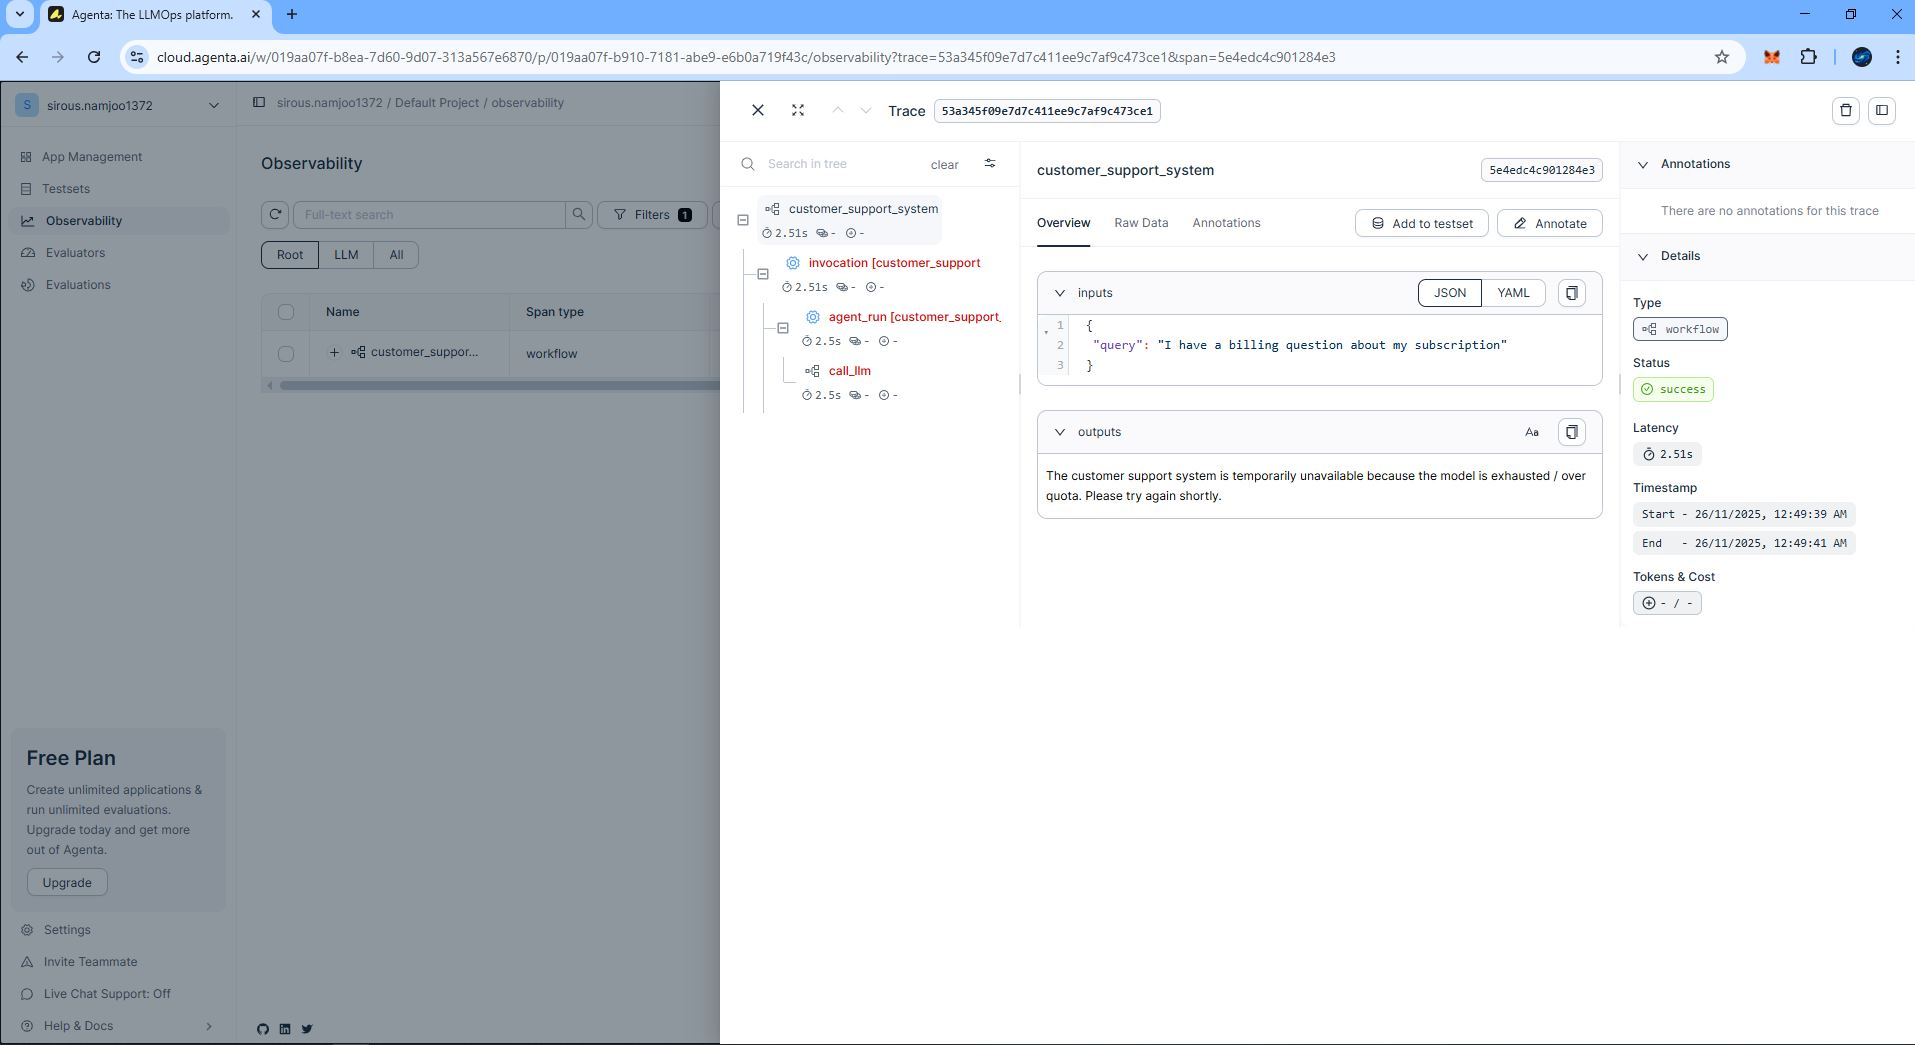

In [30]:
# Test research analysis pipeline
print("------ Research Analysis Pipeline ------")
research_response = await research_analysis_pipeline(
    "Impact of AI on healthcare"
)
print("Research Response:\n", research_response)

------ Research Analysis Pipeline ------
Research Response:
 The research pipeline could not run because the model is exhausted or over quota. Please try again later.


![Test research analysis pipeline.JPG](<attachment:Test research analysis pipeline.JPG>)
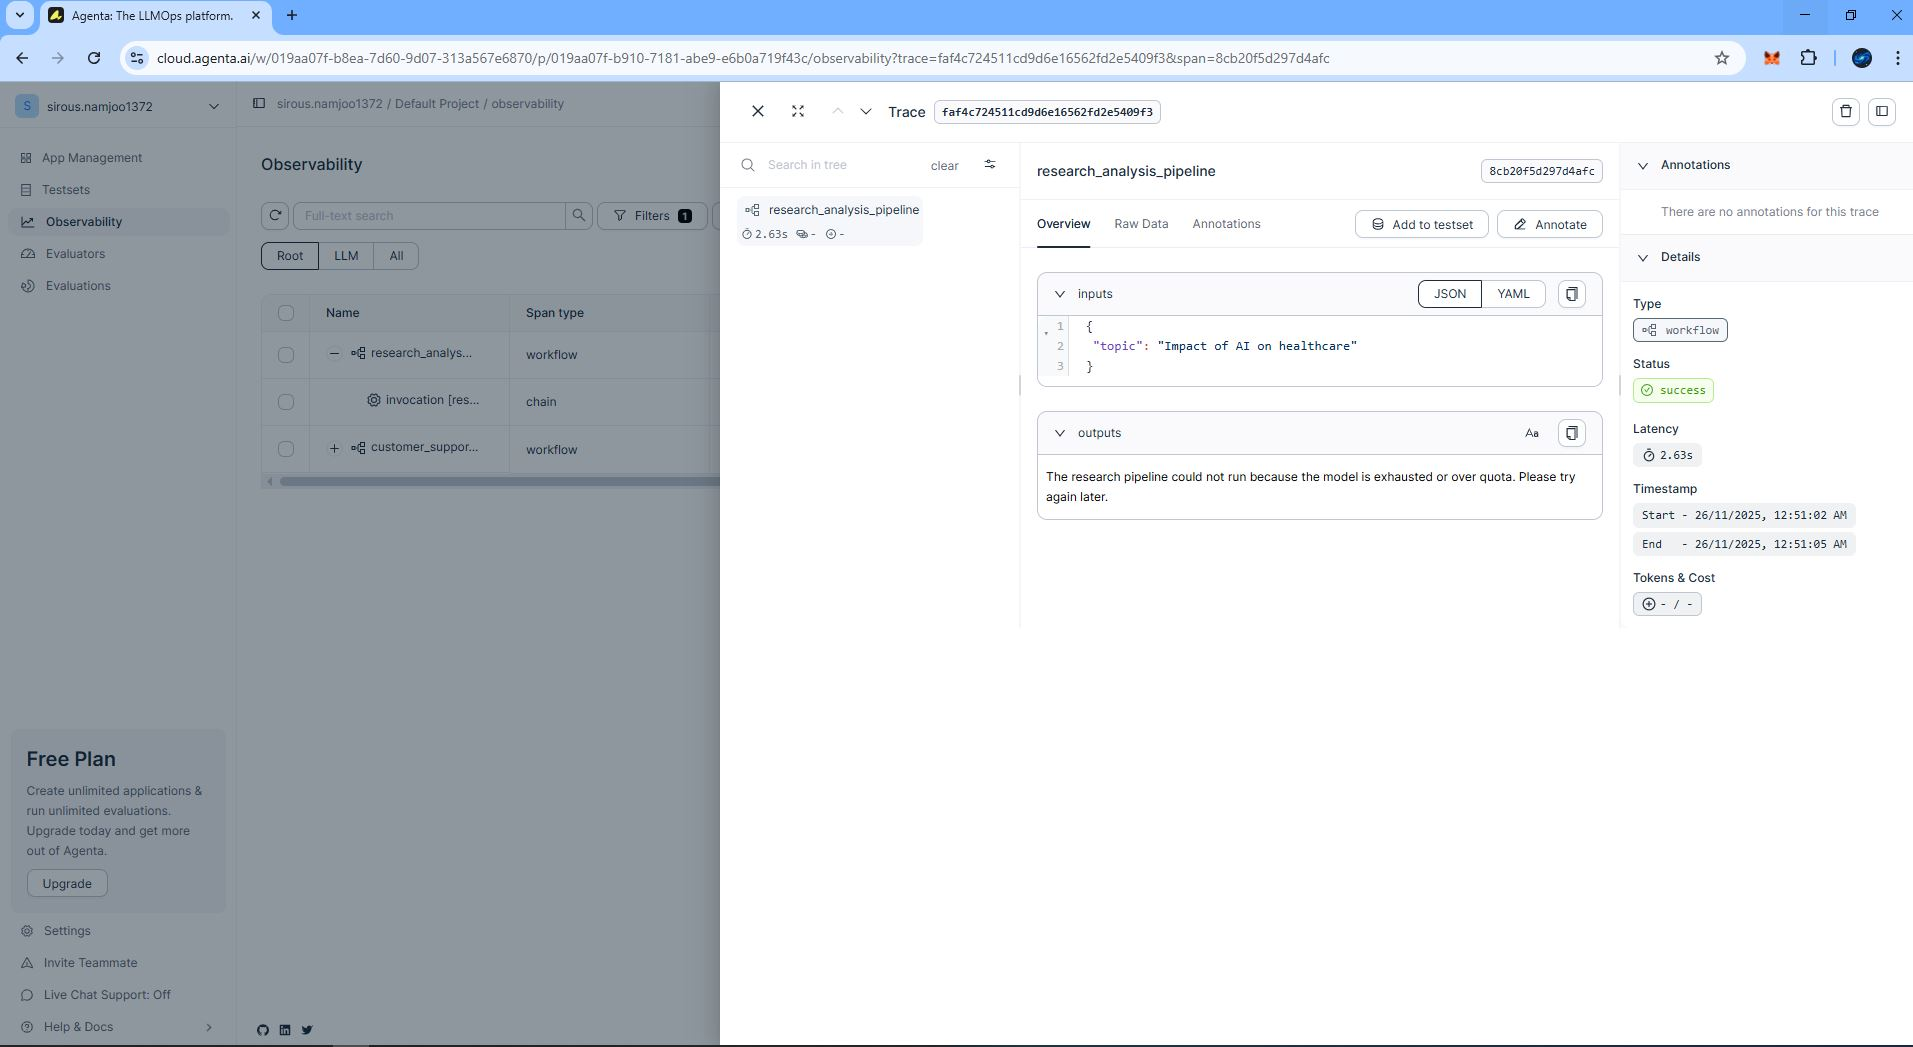

In [31]:
# Test content creation system
print("------ Content Creation System ------")
content_response = await content_creation_system(
    "Write a blog post about sustainable energy solutions"
)
print("Content Response:\n", content_response)

------ Content Creation System ------
Content Response:
 The content creation system is temporarily unavailable because the model is exhausted / over quota. Please try again later.


![Test research analysis pipeline.JPG](<attachment:Test research analysis pipeline.JPG>)
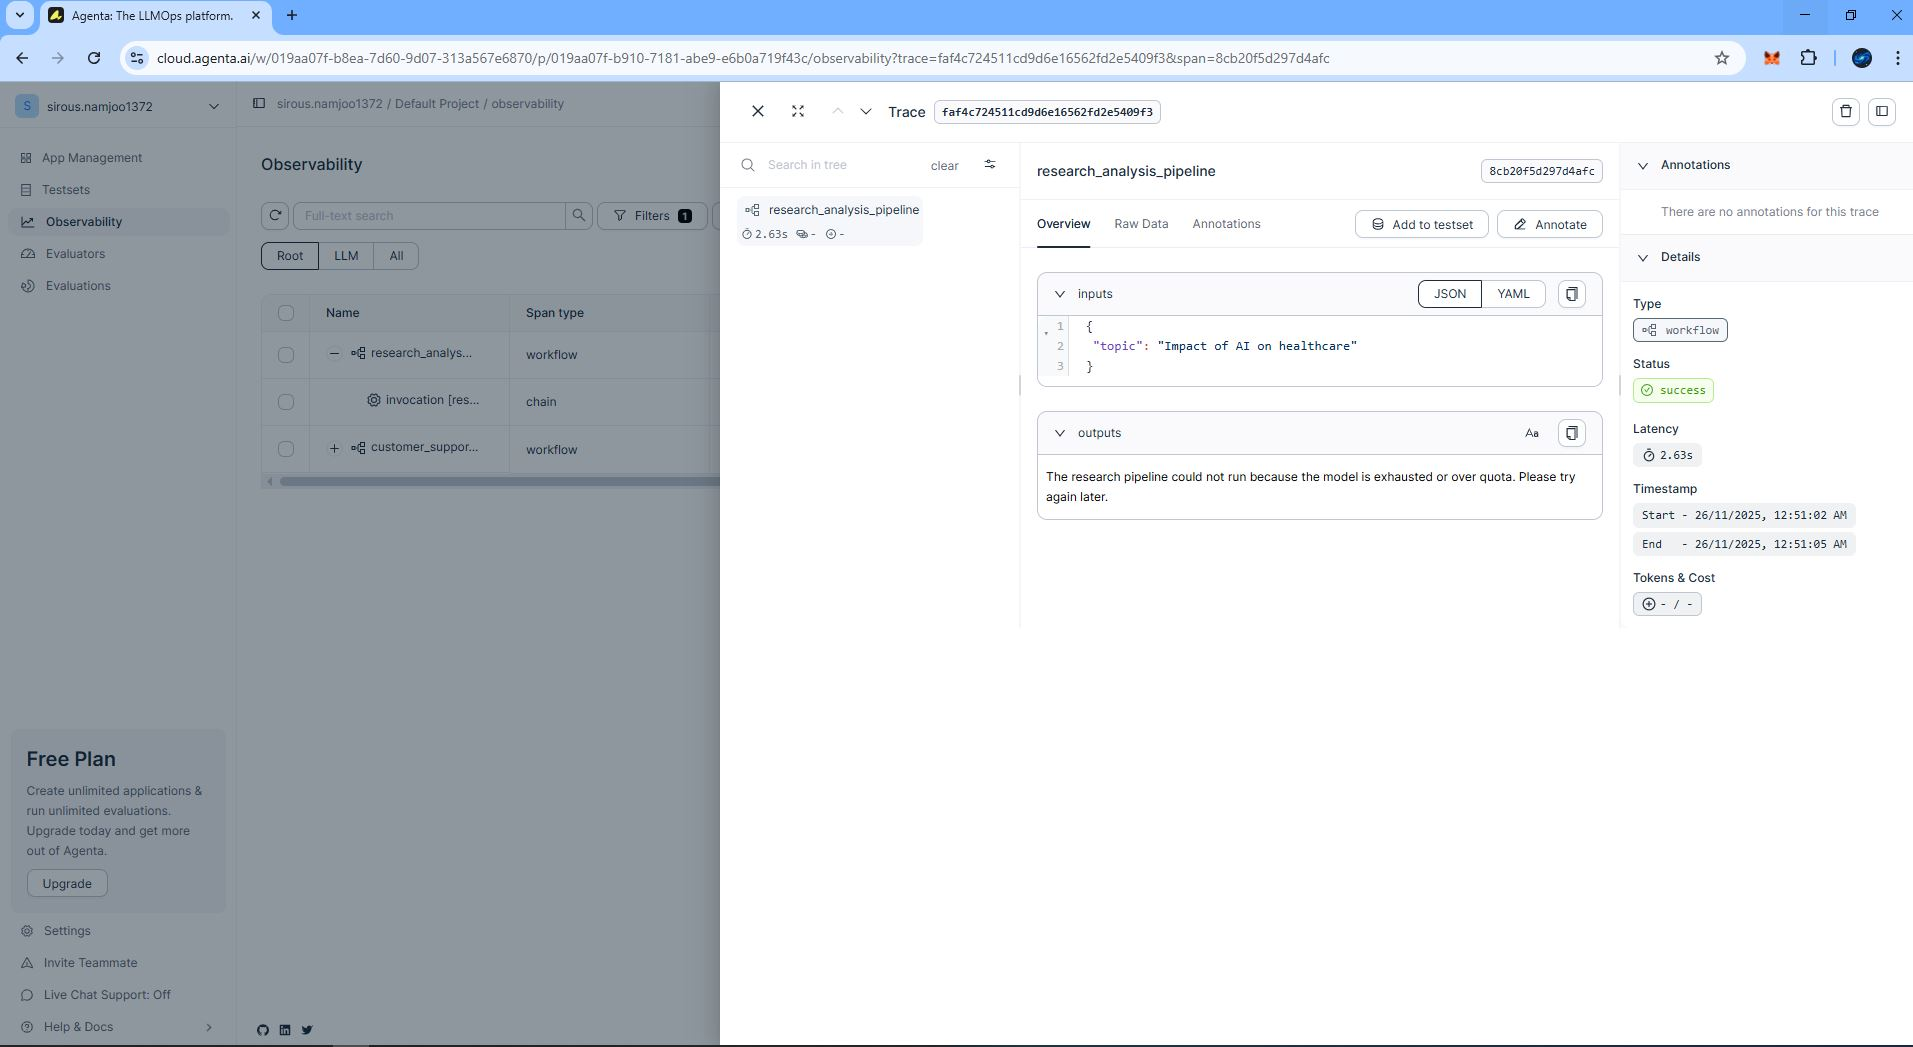

## Next Steps

For more detailed information about Agenta's observability features and advanced configuration options, visit the [Agenta Observability SDK Documentation](/observability/observability-sdk).